# Demostration of ICAROS

## The purpose of this NB is: 

- Selecting events.

- Checking run conditions are normal.

- Computing XY correction maps.


There are **some differences** with <font color='navy'>*official_map_builder_NB.ipynb*</font>:
    
   1. Here the map is only computed function-by-function (i.e. the automatic script is not used).
   
   2. The different distributions are not compared with other references.
   
   3. There are three possibilities for the band selection:  No band selection / Usual selection using a bootstrap map / Manual

## It is divided into two main sections:

1. __Section A:__ Map building showing the different steps that the script follows

2. __Section B:__ In case the map is produced, map checking.

****

# Section A: Map building

In [1]:
import os
import logging
import warnings

import numpy  as np
import glob
import matplotlib.pyplot as plt

from krcal.core.kr_types                      import masks_container
from krcal.map_builder.map_builder_functions  import calculate_map
from krcal.core.kr_types                      import FitType
from krcal.core.fit_functions                 import expo_seed
from krcal.core.selection_functions           import selection_in_band
from krcal.map_builder.map_builder_functions  import e0_xy_correction

from krcal.map_builder.map_builder_functions  import check_failed_fits
from krcal.map_builder.map_builder_functions  import regularize_map
from krcal.map_builder.map_builder_functions  import remove_peripheral
from krcal.map_builder.map_builder_functions  import add_krevol
from invisible_cities.reco.corrections        import read_maps
from krcal.core.io_functions                  import write_complete_maps

from krcal.NB_utils.xy_maps_functions         import draw_xy_maps
from krcal.core    .map_functions             import relative_errors
from krcal.core    .map_functions             import add_mapinfo

from krcal.NB_utils.plt_functions             import plot_s1histos, plot_s2histos
from krcal.NB_utils.plt_functions             import s1d_from_dst, s2d_from_dst
from krcal.NB_utils.plt_functions             import plot_selection_in_band

from invisible_cities.core.configure          import configure
from invisible_cities.io.dst_io               import load_dst, load_dsts
from invisible_cities.core.core_functions     import in_range
from invisible_cities.core.core_functions     import shift_to_bin_centers
from invisible_cities.core.fit_functions      import profileX

*Set input/output variables and configuration file*

In [2]:
run_number = 7751 # 0 or negative for MC

In [3]:
input_folder       = f'/analysis/{run_number}/hdf5/prod/v1.2.0/20191122/kdst/trigger1/'
input_dst_file     = '*.h5'
input_dsts         = glob.glob(input_folder + input_dst_file)
output_maps_folder = '/data5/users/ausonandres/maps_analysis/Kr_lt/maps/'

map_file_out     = os.path.join(output_maps_folder, f'map_{run_number}_test.h5')
histo_file_out   = os.path.join(output_maps_folder, f'hists_{run_number}_test.h5')

print('Input dst: ', input_folder + input_dst_file)
print('Output map file: ', map_file_out)
print('Output histograms file: ', histo_file_out)

Input dst:  /analysis/7751/hdf5/prod/v1.2.0/20191122/kdst/trigger1/*.h5
Output map file:  /data5/users/ausonandres/maps_analysis/Kr_lt/maps/map_7751_test.h5
Output histograms file:  /data5/users/ausonandres/maps_analysis/Kr_lt/maps/hists_7751_test.h5


which band selection do you want to be applied?

- None

- bootstrap

- manual

To illustrate, the three methods have been tested for run 7751, and the energy resolution at the Krypton peak obtained was:

- "None"      : 4.026 %
- "manual"    : 3.962 %
- "bootrstrap": 3.976 %

In [4]:
band_selection = 'manual'
if band_selection=='None': print('No selection will be made')
elif band_selection=='manual': print('The band selection will be applied manually')
elif band_selection=='bootstrap':
    bootstrap_filename = '/home/ausonandres/IC/invisible_cities/database/test_data/kr_emap_xy_100_100_r_6573_time.h5'
    bootstrapmap = read_maps(bootstrap_filename)
    print(f'Bootstrap map: {bootstrap_filename}')
    draw_xy_maps(bootstrapmap)

The band selection will be applied manually


#### Loading data (only events inside detector chamber; i.e. R<=200)

In [5]:
dst = load_dsts(input_dsts, 'DST', 'Events')
dst = dst.sort_values(by=['time'])
dst = dst[in_range(dst.R, 0, 200)]

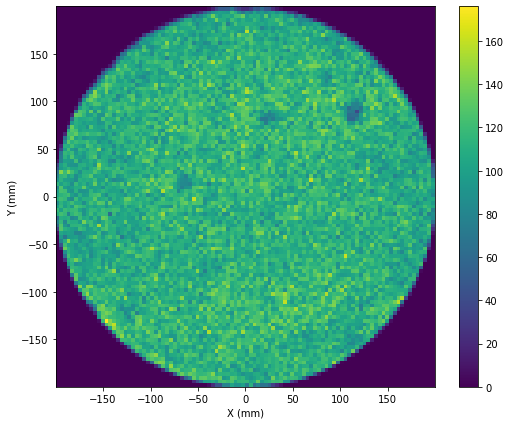

In [6]:
plt.figure(figsize=(8.5, 7));
plt.hist2d(dst.X, dst.Y, 100);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.colorbar();

### Rate before selections

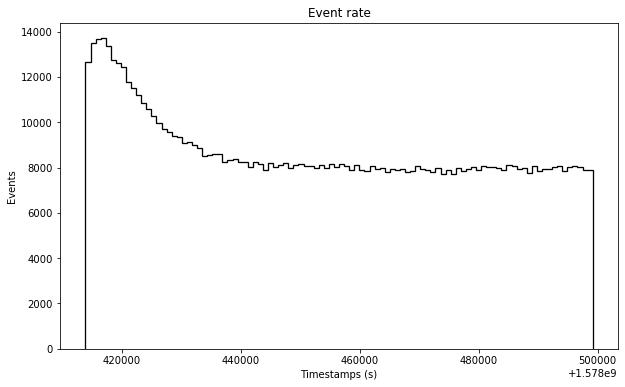

In [7]:
if run_number>0:
    plt.figure(figsize=(10, 6));
    plt.hist(dst.time, 100, histtype='step', color='k', linewidth=1.3)
    plt.xlabel('Timestamps (s)');
    plt.ylabel('Events');
    plt.title('Event rate');

## Event selection

### nS1 selection

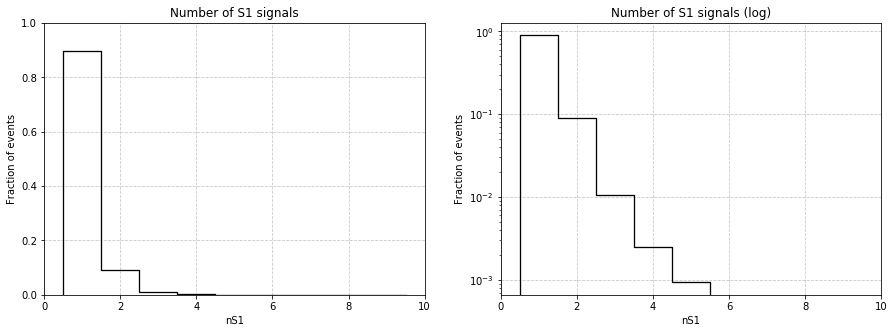

In [8]:
plt.figure(figsize=(15,5));
plt.subplot(121);
y, x = np.histogram(dst.drop_duplicates(subset='event').nS1, 10, (0, 10))
plt.step(shift_to_bin_centers(x), y/dst.event.nunique(), color='k', linewidth=1.3)
plt.xlim(0, 10);
plt.ylim(0, 1);
plt.grid(True, alpha=0.7, linestyle='--');
plt.xlabel('nS1');
plt.ylabel('Fraction of events');
plt.title('Number of S1 signals');
plt.subplot(122);
plt.step(shift_to_bin_centers(x), y/dst.event.nunique(), color='k', linewidth=1.3)
plt.xlim(0, 10);
plt.xlabel('nS1');
plt.ylabel('Fraction of events');
plt.title('Number of S1 signals (log)');
plt.yscale('log');
plt.grid(True, alpha=0.7, linestyle='--');

In [9]:
eff = dst[dst.nS1==1].event.nunique()/dst.event.nunique()
print('S1 selection efficiency: ', eff*100, '%')

S1 selection efficiency:  89.61842629691007 %


In [10]:
mask_s1 = dst.nS1==1

*Some other S1 plots:*

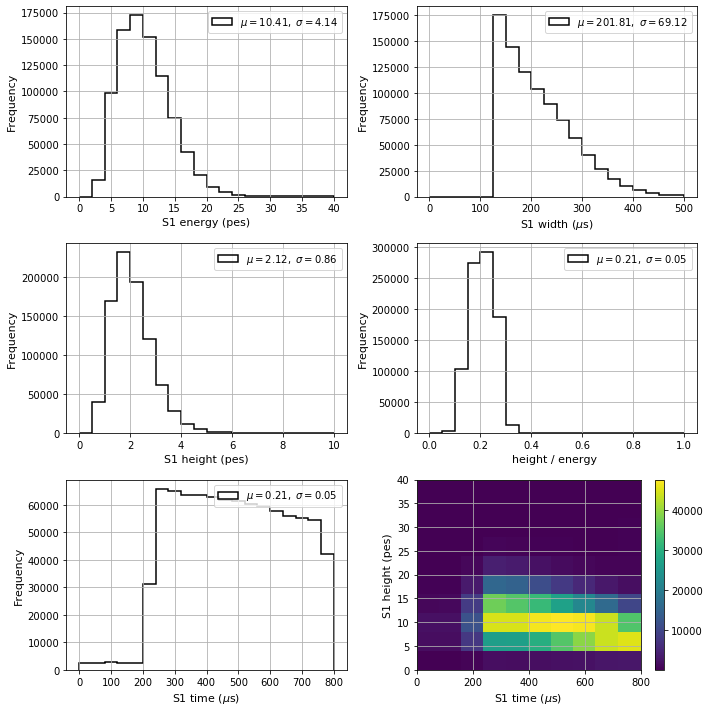

In [11]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### nS2 selection

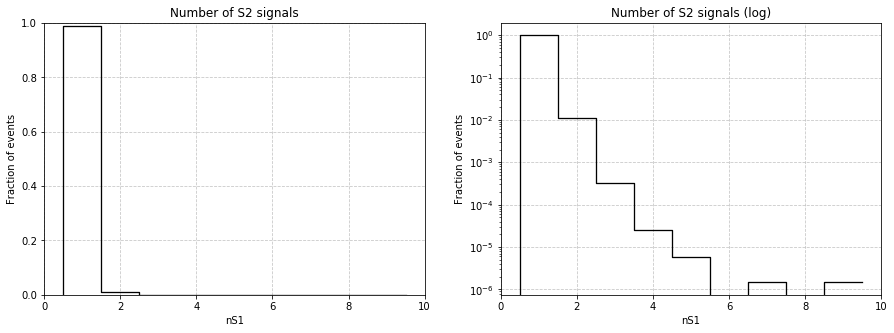

In [12]:
plt.figure(figsize=(15,5));
plt.subplot(121);
y, x = np.histogram(dst[mask_s1].drop_duplicates(subset='event').nS2, 10, (0, 10))
plt.step(shift_to_bin_centers(x), y/dst[mask_s1].event.nunique(), color='k', linewidth=1.3)
plt.xlim(0, 10);
plt.ylim(0, 1);
plt.grid(True, alpha=0.7, linestyle='--');
plt.xlabel('nS1');
plt.ylabel('Fraction of events');
plt.title('Number of S2 signals');
plt.subplot(122);
plt.step(shift_to_bin_centers(x), y/dst[mask_s1].event.nunique(), color='k', linewidth=1.3)
plt.xlim(0, 10);
plt.xlabel('nS1');
plt.ylabel('Fraction of events');
plt.title('Number of S2 signals (log)');
plt.yscale('log');
plt.grid(True, alpha=0.7, linestyle='--');

In [13]:
mask_s2 = np.zeros_like(mask_s1)
mask_s2[mask_s1] = dst[mask_s1].nS2 == 1
nevts_after      = dst[mask_s2].event.nunique()
nevts_before     = dst[mask_s1].event.nunique()
eff              = nevts_after / nevts_before
print('S2 selection efficiency: ', eff*100, '%')

S2 selection efficiency:  98.87572562145967 %


*Some other S2 plots:*

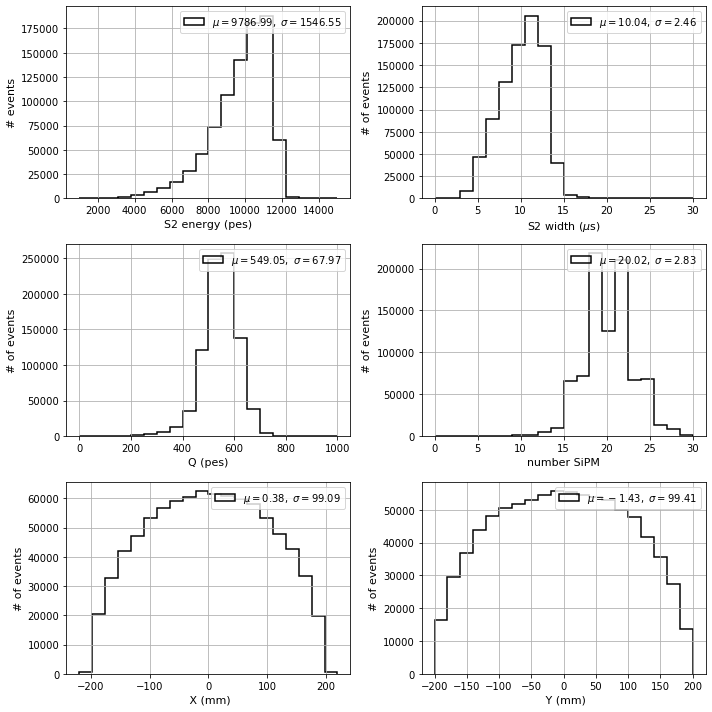

In [14]:
s2d = s2d_from_dst(dst[mask_s1])
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Band selection

In [15]:
z_range_plot = (0, 600)
e_range_plot = (0, 18000)

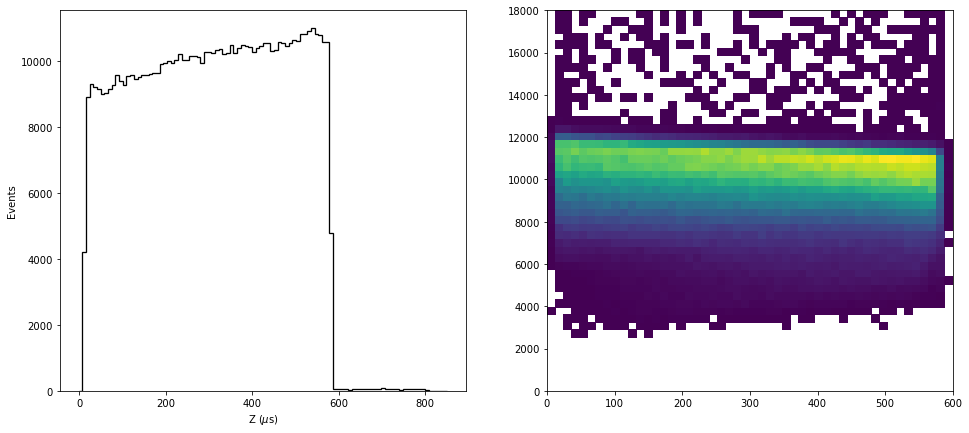

In [18]:
plt.figure(figsize=(16, 7));
plt.subplot(121);
plt.hist(dst[mask_s2].Z, 100, histtype='step', linewidth=1.3, color='k');
plt.xlabel(r'Z ($\mu$s)');
plt.ylabel('Events');
plt.subplot(122);
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, [z_range_plot, e_range_plot], cmin=1);

In [19]:
if band_selection=='None':
    sel_krband = mask_s2

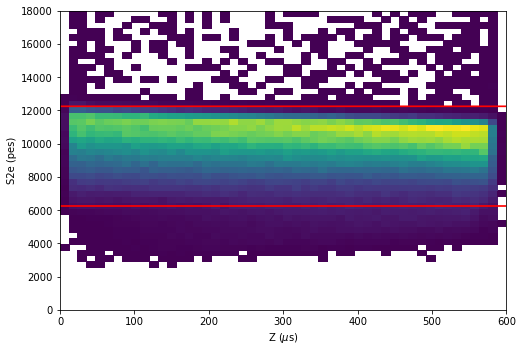

In [22]:
if band_selection=='manual':
    x, y, _ = profileX(dst[mask_s2].Z, dst[mask_s2].S2e, yrange=e_range_plot)
    e0_seed, lt_seed = expo_seed(x, y)
    lower_e0, upper_e0 = e0_seed-4000, e0_seed+2000    # play with these values to make the band broader or narrower
    
    plt.figure(figsize=(8, 5.5))
    xx = np.linspace(z_range_plot[0], z_range_plot[1], 100)
    plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, [z_range_plot, e_range_plot], cmin=1);
    plt.plot(xx, (lower_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
    plt.plot(xx, (upper_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
    plt.xlabel(r'Z ($\mu$s)');
    plt.ylabel('S2e (pes)');
    
    sel_krband = np.zeros_like(mask_s2)
    Zs = dst[mask_s2].Z
    sel_krband[mask_s2] = in_range(dst[mask_s2].S2e, (lower_e0)*np.exp(Zs/lt_seed), (upper_e0)*np.exp(Zs/lt_seed))

In [26]:
if band_selection=='bootstrap':
    
    band_sel_params = dict(
    range_z = (10, 550)      ,
    range_e = (10.0e+3,14e+3),
    nbins_z = 50             ,
    nbins_e = 50             ,
    nsigma  = 3.5            )
    
    geom_corr = e0_xy_correction(bootstrapmap)
    corr = geom_corr(dst[mask_s2].X.values, dst[mask_s2].Y.values)
    E0   = dst[mask_s2].S2e.values * corr
    
    sel_krband = np.zeros_like(mask_s2)
    sel_krband[mask_s2], fpl, fph, hp, pp = selection_in_band(dst[mask_s2].Z, E0, **band_sel_params)
    print('Band selection efficiency: ', dst[sel_krband].event.nunique()/dst[mask_s2].event.nunique()*100, '%')
    
    plot_selection_in_band(fpl, fph, hp, pp, nsigma = band_sel_params['nsigma'])

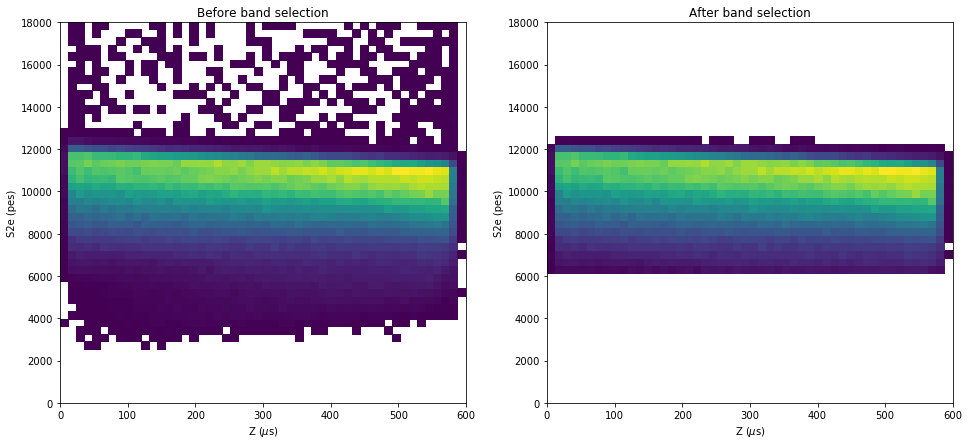

In [23]:
if band_selection!='None':
    plt.figure(figsize=(16, 7));
    plt.subplot(121);
    plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, [z_range_plot, e_range_plot], cmin=1);
    plt.xlabel(r'Z ($\mu$s)');
    plt.ylabel('S2e (pes)');
    plt.title('Before band selection')
    plt.subplot(122);
    plt.hist2d(dst[sel_krband].Z, dst[sel_krband].S2e, 50, [z_range_plot, e_range_plot], cmin=1);
    plt.xlabel(r'Z ($\mu$s)');
    plt.ylabel('S2e (pes)');
    plt.title('After band selection')

In [24]:
sel_dst = dst[sel_krband]

#### Post-selection distributions

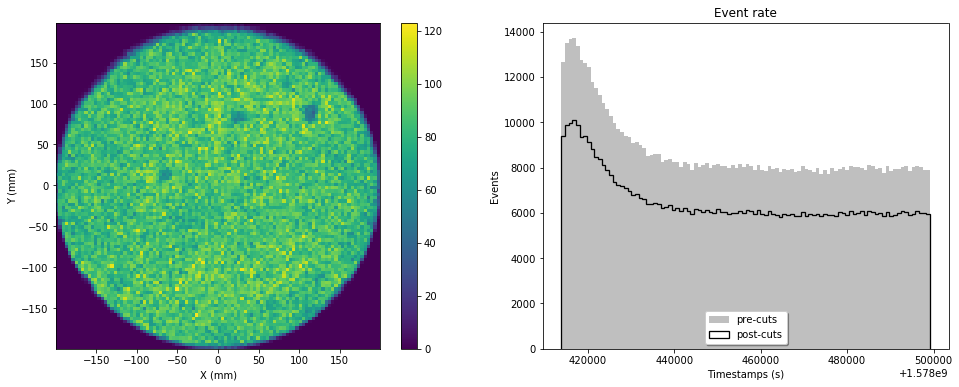

In [25]:
plt.figure(figsize=(16, 6));
plt.subplot(121);
plt.hist2d(sel_dst.X, sel_dst.Y, 100);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.colorbar();
if run_number>0:
    plt.subplot(122);
    plt.hist(dst.time, 100, alpha=0.5, color='grey', label='pre-cuts')
    plt.hist(sel_dst.time, 100, histtype='step', color='k', linewidth=1.3, label='post-cuts')
    plt.legend(shadow=True, loc='lower center');
    plt.xlabel('Timestamps (s)');
    plt.ylabel('Events');
    plt.title('Event rate');

## Map production

#### Selection of number of XY bins

Number of XY bins commonly used (in NEW);
- If the number of selected evts is greater than 1e6 -> 100x100 map
- If the number of selected evts is lower than 1e6 -> 50x50 map

In [27]:
print(sel_dst.event.nunique(), 'events')

653306 events


In [28]:
number_of_bins = 50
print('Number of XY bins: ', number_of_bins)

Number of XY bins:  50


### Map computation

In [29]:
map_params = {'nbins_z': 30,
              'nbins_e': 25,
              'z_range': (20, 550),
              'e_range': (7000, 15000),
              'chi2_range': (0, 10),
              'lt_range': (7000, 20000),
              'nmin': 100,
              'maxFailed': 10000,
              'r_max': 500,
              'r_fid': 100,
              'nStimeprofile': 1800,
              'x_range': (-200, 200),
              'y_range': (-200, 200)}

In [30]:
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [31]:
maps = calculate_map(dst        = sel_dst                 ,
                     XYbins     = (number_of_bins         ,
                                   number_of_bins)        ,
                     nbins_z    = map_params['nbins_z']   ,
                     nbins_e    = map_params['nbins_e']   ,
                     z_range    = map_params['z_range']   ,
                     e_range    = map_params['e_range']   ,
                     chi2_range = map_params['chi2_range'],
                     lt_range   = map_params['lt_range']  ,
                     fit_type   = FitType.unbined         ,
                     nmin       = map_params['nmin']      ,
                     x_range    = map_params['x_range']   ,
                     y_range    = map_params['y_range']   )

### Last check: number of failed fits

In [32]:
maxFailed = map_params['maxFailed']
r_max     = map_params['r_max']

check_failed_fits(maps      = maps          ,
                  maxFailed = maxFailed     ,
                  nbins     = number_of_bins,
                  rmax      = r_max         ,
                  rfid      = r_max         )

    Number of failing fits: 94


#### chi2 regularization and compute relative error maps, instead of absolute error.

In [33]:
regularized_maps = regularize_map(maps    = maps                    ,
                                  x2range = map_params['chi2_range'])

regularized_maps = relative_errors(am = regularized_maps)

In [1]:
regularized_maps

NameError: name 'regularized_maps' is not defined

Now, the outer bins are replaced by nans:

In [34]:
regularized_maps = remove_peripheral(map   = regularized_maps,
                                     nbins = number_of_bins  ,
                                     rmax  = r_max           ,
                                     rfid  = r_max           )

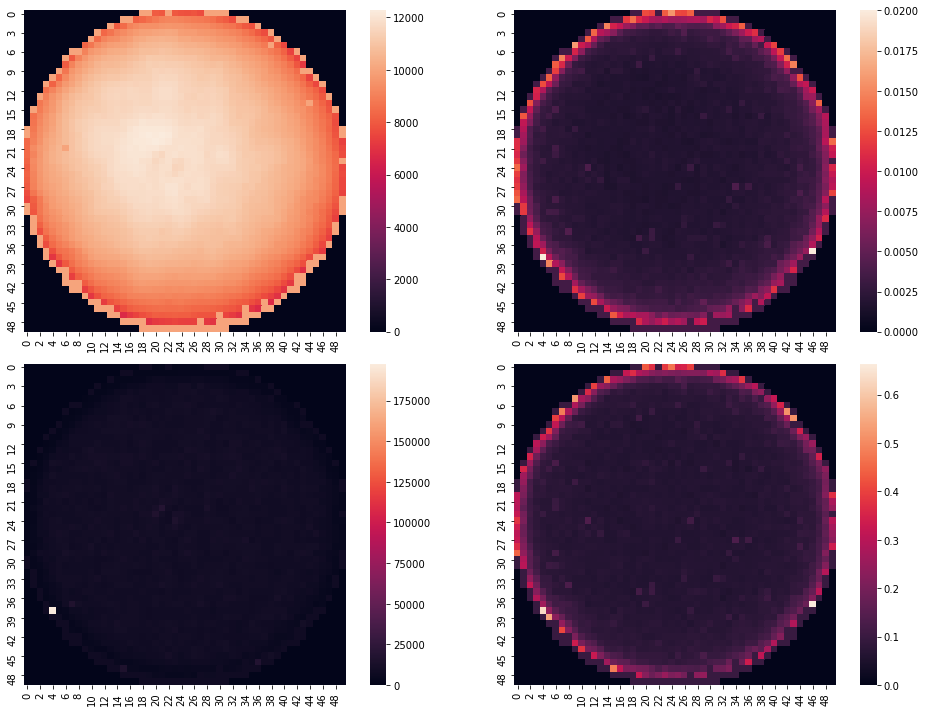

In [35]:
draw_xy_maps(regularized_maps,
             #ltlims = (0, 40000),
             figsize=(14,10))

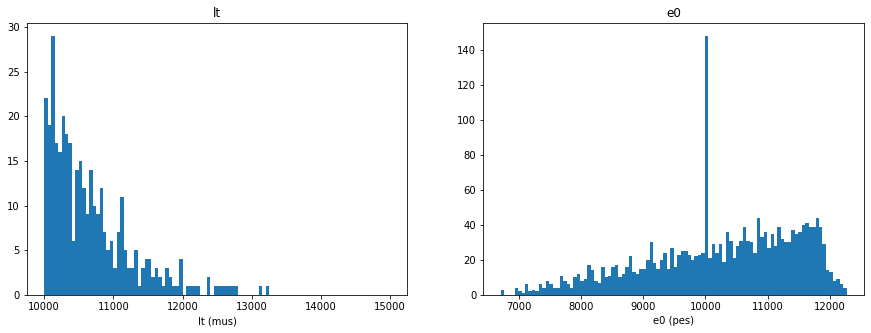

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(regularized_maps.lt.values.flatten(), 100, (10000, 15000));
plt.title('lt')
plt.xlabel('lt (mus)');
plt.subplot(122)
plt.hist(regularized_maps.e0.values.flatten(), 100);
plt.title('e0')
plt.xlabel('e0 (pes)');

#### Mapinfo table is added

In [37]:
maps = add_mapinfo(asm        = regularized_maps     ,
                   xr         = map_params['x_range'],
                   yr         = map_params['y_range'],
                   nx         = number_of_bins       ,
                   ny         = number_of_bins       ,
                   run_number = run_number           )
print(maps.mapinfo)

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    7751
dtype: int64


#### Temporal evolution table is added FOR DATA

In [38]:
if run_number>0:
    masks = masks_container(s1   = mask_s1,
                            s2   = mask_s2,
                            band = sel_krband)

    r_fid         = map_params['r_fid']
    nStimeprofile = map_params['nStimeprofile']
    add_krevol(maps          = maps                 ,
               dst           = dst                  ,
               masks_cuts    = masks                ,
               r_fid         = r_fid                ,
               nStimeprofile = nStimeprofile        ,
               x_range       = map_params['x_range'],
               y_range       = map_params['y_range'],
               XYbins        = (number_of_bins      ,
                                number_of_bins     ))
    temp = maps.t_evol

    Mean core E0: 12276.8+-38.3 pes
    Mean core Lt: 9797.9+-298.6 mus


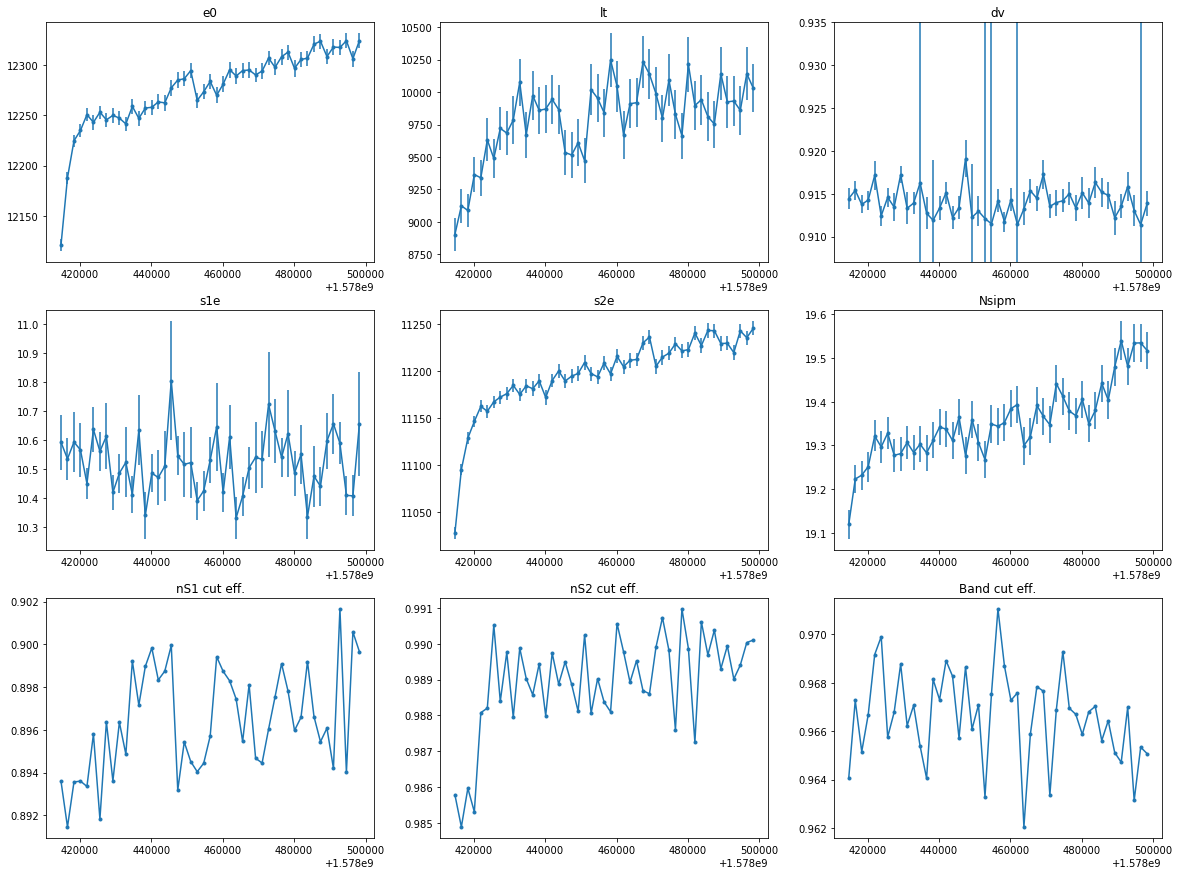

In [39]:
if run_number>0:
    plt.figure(figsize=(20, 15));
    plt.subplot(3,3,1);
    plt.title('e0');
    plt.errorbar(temp.ts, temp.e0, temp.e0u, fmt='.', linestyle='-');
    plt.subplot(3,3,2);
    plt.title('lt');
    plt.errorbar(temp.ts, temp['lt'], temp['ltu'], fmt='.', linestyle='-');
    plt.subplot(3,3,3);
    plt.title('dv');
    plt.ylim(0.907, 0.935);
    plt.errorbar(temp.ts, temp.dv, temp.dvu, fmt='.', linestyle='-');
    plt.subplot(3,3,4);
    plt.title('s1e');
    plt.errorbar(temp.ts, temp.s1e, temp.s1eu, fmt='.', linestyle='-');
    plt.subplot(3,3,5);
    plt.title('s2e');
    plt.errorbar(temp.ts, temp.s2e, temp.s2eu, fmt='.', linestyle='-');
    plt.subplot(3,3,6);
    plt.title('Nsipm');
    plt.errorbar(temp.ts, temp.Nsipm, temp.Nsipmu, fmt='.', linestyle='-');
    plt.subplot(3,3,7);
    plt.title('nS1 cut eff.');
    plt.errorbar(temp.ts, temp.S1eff, fmt='.', linestyle='-');
    plt.subplot(3,3,8);
    plt.title('nS2 cut eff.');
    plt.errorbar(temp.ts, temp.S2eff, fmt='.', linestyle='-');
    plt.subplot(3,3,9);
    plt.title('Band cut eff.');
    plt.errorbar(temp.ts, temp.Bandeff, fmt='.', linestyle='-');

### Writing final map

In [40]:
write_complete_maps(asm      = maps        ,
                    filename = map_file_out)

*****

# Section C: Checking map <a id='SectionC'></a>

In [41]:
print(f'Opening computed map: {map_file_out}')
final_map = read_maps(map_file_out)

Opening computed map: /data5/users/ausonandres/maps_analysis/Kr_lt/maps/map_7751_test.h5


In [42]:
from krcal.NB_utils.plt_functions             import h1, h2
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy
from krcal.NB_utils.plt_energy_functions      import resolution_r_z, plot_resolution_r_z
from invisible_cities.reco.corrections        import apply_all_correction

#### Applying correction to the selected dst

In [43]:
sel_dst = sel_dst[sel_dst.R<100]

In [44]:
geom_corr = e0_xy_correction(final_map)
if run_number>0: total_correction = apply_all_correction(final_map, apply_temp=True)
else:
    total_correction = apply_all_correction(final_map, apply_temp=False)
    print('Temporal corrections will not be applied since MC maps do not contain time-dependence information.')

corr_geo = geom_corr(sel_dst.X, sel_dst.Y)
corr_tot = total_correction(sel_dst.X, sel_dst.Y, sel_dst.Z, sel_dst.time)

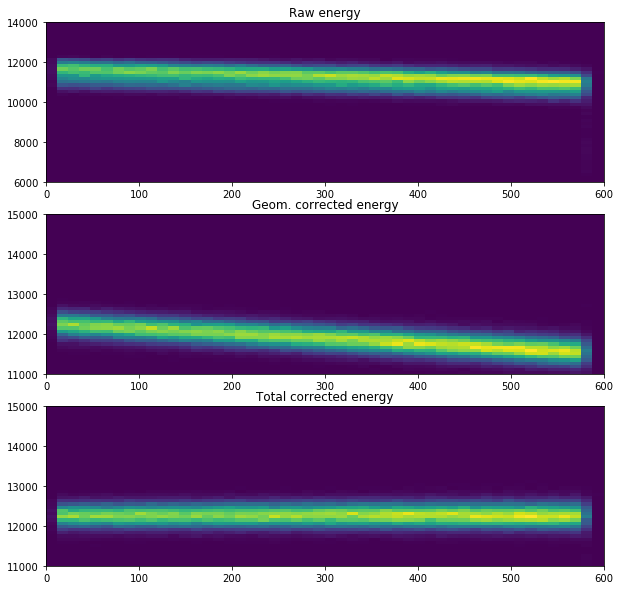

In [45]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.hist2d(sel_dst.Z, sel_dst.S2e, 50, [(0,600),(6000,14000)])
plt.title('Raw energy');
plt.subplot(3, 1, 2)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_geo, 50, [(0,600),(11000,15000)])
plt.title('Geom. corrected energy');
plt.subplot(3, 1, 3)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_tot, 50, [(0,600),(11000,15000)])
plt.title('Total corrected energy');

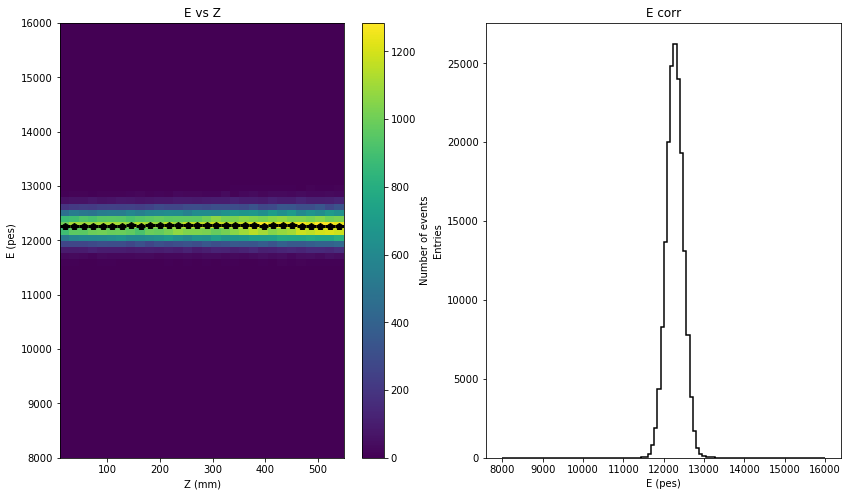

In [46]:
e_range = (8000,16000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)

nevt = h2(sel_dst.Z, sel_dst.S2e*corr_tot, 30, 70, zrange, e_range, profile=True)
plt.xlabel('Z (mm)');
plt.ylabel('E (pes)');
plt.title('E vs Z');

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(sel_dst.S2e*corr_tot,  bins = 100, range =e_range, stats=True, lbl = 'E')
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.title('E corr');

  Fit was valid = True
 Emu       = 12274.770545834292 +-0.5058142819164604 
 E sigma   = 206.9232273276848 +-0.3759858763616085 
 chi2    = 1.1860859595573479 
 sigma E/E (FWHM)     (%) =3.9615370601374322
 sigma E/E (FWHM) Qbb (%) =0.5116402614463076 


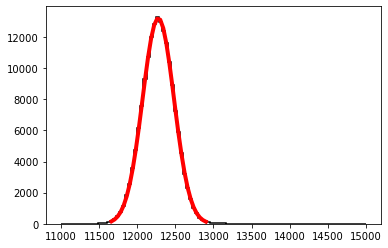

In [47]:
fc = fit_energy(sel_dst.S2e*corr_tot, nbins=100, range=(11000, 15000))
plot_fit_energy(fc)
print_fit_energy(fc)

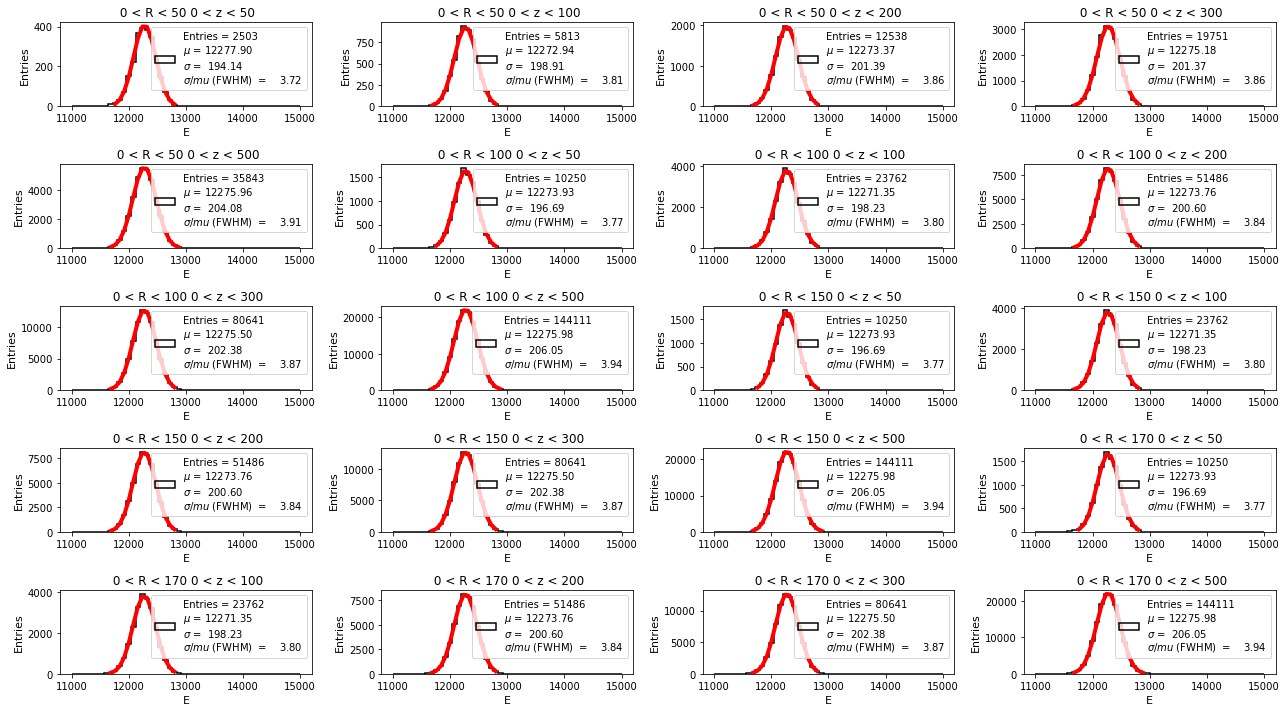

In [48]:
Ri = (50, 100,150,170)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, sel_dst.R, sel_dst.Z, sel_dst.S2e*corr_tot,
                    enbins = 50,
                    erange = (11000, 15000),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))

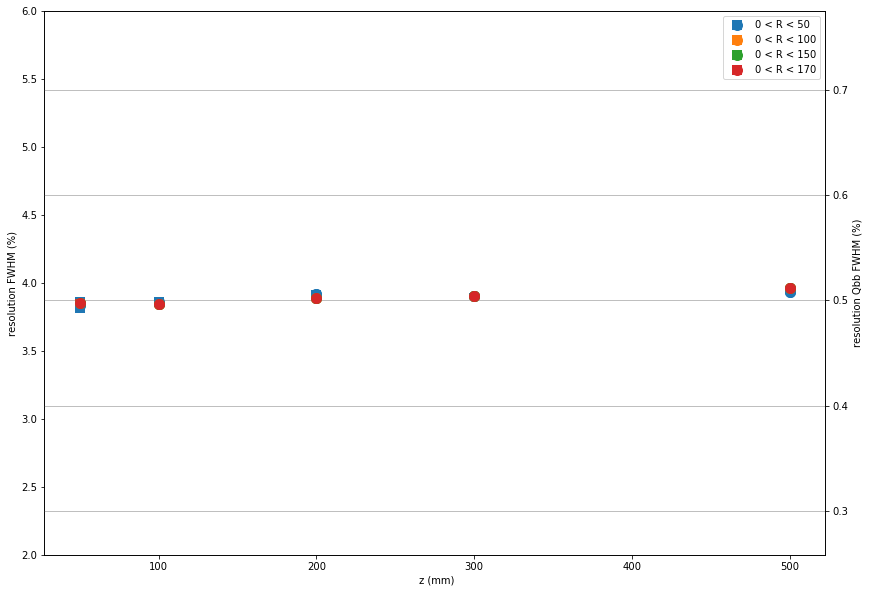

In [80]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(2,6))